<a href="https://colab.research.google.com/github/Bast-94/ML-BIO/blob/drafts/ECG_classification_exercices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
!pip install wfdb

In [88]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None)

import wfdb
import glob
import os
from scipy import signal
import pywt

# Context
Cardiovascular Disease is the main cause of humain death, responsible for 31% of the world cide deaths in 2016. The major cause of the cardiac deaths is cardiac arrhythmia. The best equipment for monitoring and identifying arrhythmia is an electrocardiogram(ECG).

By recording ECG, analysing these features and classifying signals we can make assessments about the healthy state of the heart, diagnose certain diseases of the heart and predict whether a subject will go on to develop certain diseases.

ECG (Electrocardiogram) is non-stationary physiolocial signal representing electrical activity of heart. In other words, ECG is a periodic waveform that describes the action of heart as it moves.


In this project, we will classify ECG signals to make assessments about the health state of the heart. For this purpose, we use ensemble of three PhysioNet databases: MIT-BIH Arrhythmia Database, MIT-BIH Normal Sinus Rhythm Database, and The BIDMC Congestive Heart Failure Database.

- MIT-BIH Arrhythmia database (ARR-Database) consists of 48 half-hour ECG recording from people with cardiac arrhythmia problem. Each record was sampled at 360 hertz and contains two chanels. source [here](https://www.physionet.org/content/mitdb/1.0.0/ ).

- MIT-BIH Normal Sinus Rhythm Database (NSR-Database) consists of 18 long-tern ECG recording from people with normal sinus rhythms. Records in this databased were sampled at 128 hertz.
source [here](https://www.physionet.org/content/nsrdb/1.0.0/).

- BIDMC Congestive Heart Failure Database (CHF-Database) consists of 15 long-tern ECG recording from people with congestive heart failure. Records in this databased were sampled at 250 hertz. [source](https://www.physionet.org/content/chfdb/1.0.0/)


If you want to waves : https://www.physionet.org/lightwave/?db=mitdb/1.0.0


# List of exercises

# Ex1: Plot signals and show data

There files named "101.dat" and "101.hea" which are an human electrocardiogram (ECG) record of one person with cardiac arrhythmia (ARR) problem.

1.1. Write a function named "load_record_using_wfdb(filename, start, end, channel, directory)" which reads a channel of a record from "start" to "end". Note that each record has two channels. This function returns numpy array which contains data of the signal.  
To get the data it is easier if you stream the data from physionet.  

Specify the parameter "start" = 0.


Specify the parameter "end" = 2000


1.2 By using matplotlib package, plot the signal. The signal is periodic ? Its shape is the same of a sinusoidal wave ?

**Question 1.1**

In [89]:
def bload_record_using_wfdb(filename : str, start: str, end :float, channel:list, directory:str):
  ecg_record =wfdb.rdsamp(filename, pn_dir=directory,sampfrom=start,sampto=end,channels=[channel])

  return ecg_record[0]


In [109]:
def bload_record_using_wfdb(filename: str, start: int, end: int, channel:int, directory: str):
    """
    filename: name of the record
    start: int
    end: int
    channel: list of integers (0 or 1)
    directory: directory path where the data is located
    """
    record = wfdb.rdrecord(filename, sampfrom=start, sampto=end, channels=[channel], pn_dir=directory)
    data = record.p_signal.reshape(-1)
    return data

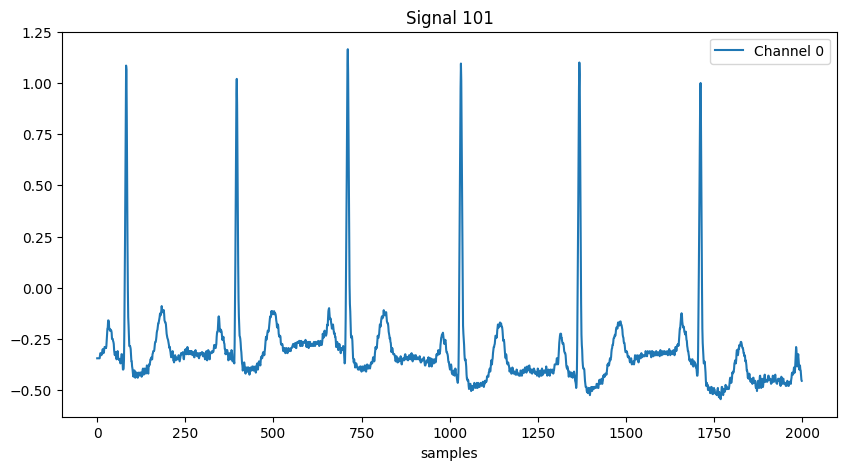

In [110]:
from matplotlib import legend
filename='101'

ecg_signal = bload_record_using_wfdb(filename=filename, start=0,end=2000,directory='mitdb',channel=0)
fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(ecg_signal,label=f'Channel 0')
ax.set_title(f'Signal {filename}')

ax.set_xlabel('samples')
ax.legend()
plt.legend()
plt.show()


# Ex2: Cut up signal
2.1.  Write a function named "split_vecto_into_chunk" that splits an array vector into chunks of size N. It takes as arguments a vector and size of chunk and returns a list of its chunks.

2.2.  ECG signals record frequently for a long period of time at different sampling rates.

Write function named "cut_signal_into_segments(signal, sampling_rate, duration_segment)" which allows to cut up a signal into shorter segments of a specified duration. This function returns a list of segments.

Note that:
        number_of_samples = sampling_rate*duration.



[Note] For sampling rate put those indicate before for each record. (360 Hz)

[Note] In addition to test your function you can try to print the original signal and the chunks in the same cell or plot

## 2.1.

In [111]:
def split_vector_into_chunk(vector: np.ndarray, N: int):
    num_blocs = vector.shape[0] // N + (vector.shape[0] % N != 0)
    blocs = []

    for i in range(num_blocs):
        debut = i * N
        fin = (i + 1) * N
        bloc = vector[debut:fin]
        blocs.append(bloc)

    return np.asarray(blocs,dtype=object)

### 2.1. Test (check function)

In [112]:
import numpy as np
list_vectors = [np.array([1,2]), np.array([1,2,3,4,5,6,7,8,9,10, 11, 12, 13,14]), np.random.rand(7)]

for vector in list_vectors:
    result = split_vector_into_chunk(vector, 3)
    print(result)

[[1 2]]
[array([1, 2, 3]) array([4, 5, 6]) array([7, 8, 9]) array([10, 11, 12])
 array([13, 14])]
[array([0.70219092, 0.1941122 , 0.09600925])
 array([0.91120339, 0.40246428, 0.81003556]) array([0.74069586])]


## 2.2.

In [113]:
def cut_signal_into_segments(signal_:np.ndarray, sampling_rate, duration_segment):
  return split_vector_into_chunk(signal_,sampling_rate*duration_segment)
sampling_rate = 360
duration_segment = 1
ecg_signal = bload_record_using_wfdb(filename=filename, start=0,end=2000,directory='mitdb',channel=0)
all_cuts = cut_signal_into_segments(ecg_signal,sampling_rate,duration_segment)

## 2.2. Test

In [114]:
for cut in all_cuts:
  assert cut.shape[0] <= sampling_rate*duration_segment

# Ex3:  Synchronize data
These records from different database were digitized at different frequences.
We recall that ECG records of ARR-Database were sampled at 360 Hz, those of CHF Database at 250 Hz and those of NSR Database at 128Hz.

3.1. With SCIPY package, write a function named "synchronize_signal" which resamples signal at any sampling rate to a common rate (for example 128 Hz). It takes as arguments a signal and its sampling rate and new sampling rate that we want to resample.

3.2.  Plot the original and resampled signals on the same figure (using subplot of matplotlib).


## 3.1. Solution

In [115]:
def synchronize_signal(signal_:np.ndarray,original_sampling_rate:float, new_sampling_rate:float):
    resampling_factor = new_sampling_rate / original_sampling_rate
    new_num_samples = int(len(signal_) * resampling_factor)
    resampled_signal = signal.resample(signal_, new_num_samples)
    return resampled_signal

### 3.1. Test

In [116]:
list_signals = [np.array([0,1,2,3,4,5,6]), np.array([1,2,3]), np.array([1,2,3,4,5,6,7,8,9,10])]
for signal_ in list_signals:
    signal_resampled = synchronize_signal(signal_, 1, 2/3)
    print(signal_resampled)

[1.        1.9234786 3.        6.0765214]
[1. 3.]
[ 2.5         2.64266616  4.02662958  6.5         6.97337042 10.35733384]


### 3.2. Test

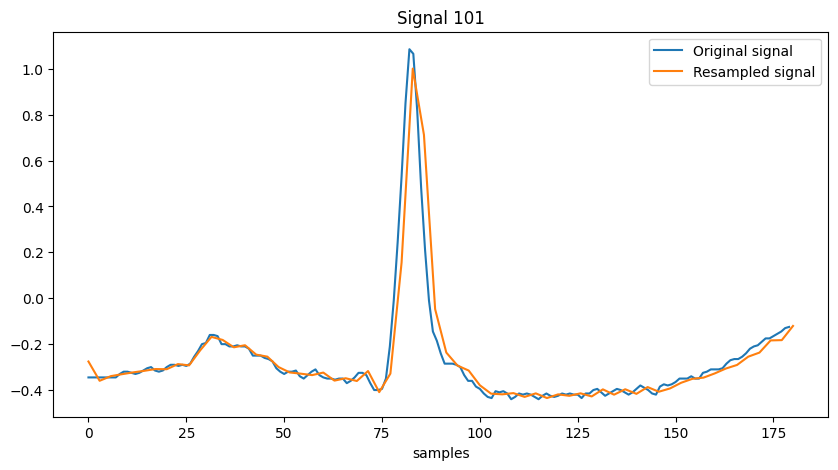

In [117]:
frequency=360
duration = 0.5
# Récupération du signal
ecg_signal = bload_record_using_wfdb(filename=filename, start=0,end=int(duration*frequency),directory='mitdb',channel=0)

fig, ax = plt.subplots(1,figsize=(10,5))
# Affichage du signal
ax.plot(ecg_signal,label=f'Original signal')

new_frequency = 128
# Synchronisation du nouveau signal à une fréquence différente
resampled_signal = synchronize_signal(ecg_signal,frequency,new_frequency)

# Nous créons un linspace de sorte à mettre les deux signaux sur la même phase
xnew = np.linspace(0,ecg_signal.shape[0],resampled_signal.shape[0])

# Nous affichons le nouveau signal
ax.plot(xnew,resampled_signal,label=f'Resampled signal')
ax.set_title(f'Signal {filename}')

ax.set_xlabel('samples')
ax.legend()
plt.legend()
plt.show()

On remarque que le signal resynchronisé possède effectivement moins d'information que l'original en faisant un comparatif des tracés.

# Ex4) Remove noise
ECG signals frequently contain some noise. There are many reasons for this:
- Activity of other body muscles
- Baseline shift because of respirators
- Poor contact of electrode
- Equiment ...

It's important to remove noise from signals. The common frequencies of the important components on the ECG from 0.5Hz - 100Hz.

An array signal named "signal_arr" is loaded in the environement.


4.1.  We note that a low pass filter that allows to passes signals with a frequency lower than a selected cutoff frequency and attenuates signals with frequencies higher than the cutoff frequency.


Using scipy.butter, design a low pass filter which filters out frequencies larger than 100Hz. Apply it to signal_arr.



4.2. Similarly, A high pass filter is used to isolate the signals which have frequencies lower than the cutoff frequency.

Design a high pass filter which filters out frequencies smaller than 0.5 Hz. Apply it to signal_arr.



4.3.  A band-pass filter can be formed by cascading a high-pass filter and a low-pass filter.

Design a band-pass filter which filters out frequencies out of range 0.5Hz - 100Hz. Apply it to signal_arr.

4.4.  Plot these signals on the same figure (using the method "matplotlib.pyplot.subplots"). Do you have any comments on the magnitude of these signals ? Did the shape of the origine signal change after passing through one of these filter ?

## Solution

In [ ]:
from scipy import signal as scipy_signal
highpass = 0.1
lowpass = 100

In [ ]:
a_low, b_low = scipy_signal.butter(6, lowpass, btype='lowpass', analog = True)
signal_filtered_lowpass = scipy_signal.filtfilt(b_low, a_low, signal_arr)


# Ex5)  Discrete Wavelet Transform (DWT)
A way of splitting a signal into several frequency sub-bands is to use Discrete Wavelet transform (DWT). The output of DWT contains two sets of coefficients: the approximation coefficients and detail coefficient.


5.1 Using package pywt in Python, decompose a ECG signal using DWT. Plot the approximation coeffs and detail coeffs on the same figure (using the method subplots of matplotlib )

Do you have comments on the magnitude of approximation coeffs and that of detail coeffs, compare them to that of origine signal ? Did you see the diffence between the origine signal and the approximation coeffs ?

5.2 We can again apply DWT on the approximation coefficients of the previous DWT to get the next level. The method pywt.wavedec() allows us to immediately calculate the coefficients of a higher level.  Using this method, calculate the coeffs of your signal until levels 5. Plot these coeffs on the same figure.


How many are there sets of the coeffs at level 5? Compare these sets of the coeffs to the origine signal. Which one approximates the origine signal ? What is the difference between the 6th coeffs and the detail coeffs ( in exercise 1) ?  Could you deduce how the DWT works ?
When we increase detail levels, what happen between between original signal and its approximation coefficients ?

## Solution

**5.1**
 *Using package pywt in Python, decompose a ECG signal using DWT. Plot the approximation coeffs and detail coeffs on the same figure*

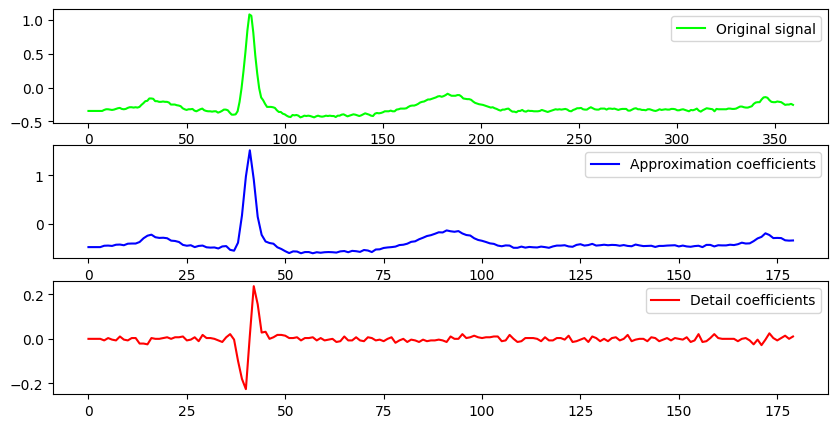

In [123]:
ecg_signal = bload_record_using_wfdb(filename=filename, start=0,end=360,directory='mitdb',channel=0)

approximation_coeffs, details_coeffs = pywt.dwt(ecg_signal, 'db1')
fig, ax = plt.subplots(3, figsize=(10,5))
ax[0].plot(ecg_signal, label="Original signal",color=(0,1,0))
ax[0].legend()
ax[1].plot(approximation_coeffs, label="Approximation coefficients",color=(0,0,1))
ax[1].legend()
ax[2].plot(details_coeffs, label="Detail coefficients",color=(1,0,0))
plt.legend()
plt.show()


*Do you have comments on the magnitude of approximation coeffs and that of detail coeffs, compare them to that of origine signal ? *

On remarque que les coefficients d'approximation  et le signal original possède la même allure. Concernant les coefficients de détail ils restent proches de 0 lorsque le signal est peu variable et ils prennent des valeurs plus éloginées de 0 lorsque que le signal a des variations élevées.

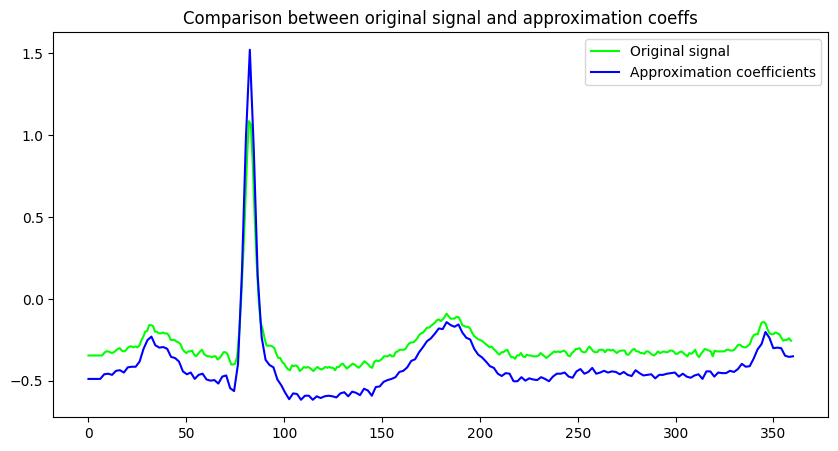

In [125]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(ecg_signal, label="Original signal",color=(0,1,0))
xnew = np.linspace(0,ecg_signal.shape[0],approximation_coeffs.shape[0])
ax.plot(xnew,approximation_coeffs, label="Approximation coefficients",color=(0,0,1))
ax.legend()
ax.set_title('Comparison between original signal and approximation coeffs')
plt.show()

*Did you see the diffence between the origine signal and the approximation coeffs ?*

On remarque que les coefficients d'approximation possèdent une plus grande amplitude que le signal original.

**5.2**
*We can again apply DWT on the approximation coefficients of the previous DWT to get the next level. The method pywt.wavedec() allows us to immediately calculate the coefficients of a higher level. Using this method, calculate the coeffs of your signal until levels 5. Plot these coeffs on the same figure.*

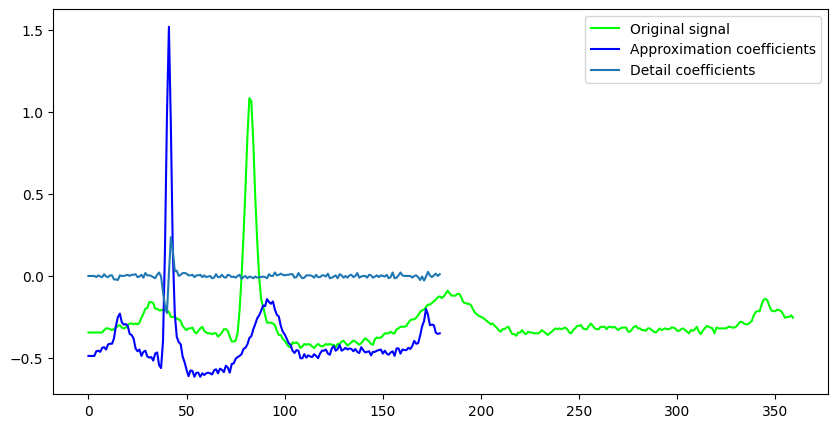

In [126]:
ecg_signal = bload_record_using_wfdb(filename=filename, start=0,end=360,directory='mitdb',channel=0)
coeffs = pywt.wavedec(ecg_signal,'db1',level=1)
approximation_coeffs = coeffs[0]

fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(ecg_signal, label="Original signal",color=(0,1,0))
ax.plot(approximation_coeffs, label="Approximation coefficients",color=(0,0,1))
for details_coeffs in coeffs[1:]:
  ax.plot(details_coeffs, label="Detail coefficients")

plt.legend()
plt.show()

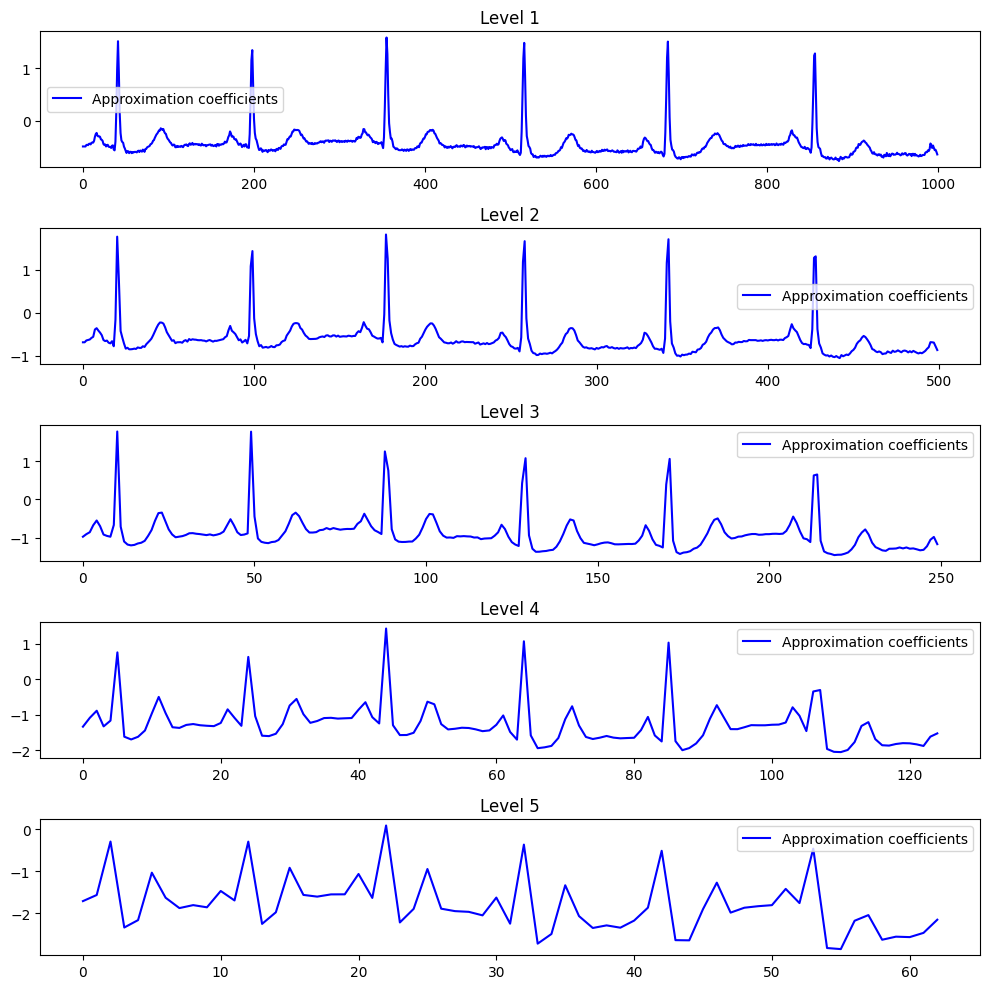

In [131]:

ecg_signal = bload_record_using_wfdb(filename=filename, start=0,end=2000,directory='mitdb',channel=0)

n_levels = 5
fig, axs = plt.subplots(n_levels,1 , figsize=(10, 2* (n_levels )))


# Effectuer la décomposition et afficher les coefficients pour chaque niveau
for level in range(0, n_levels ):
    coeffs = pywt.wavedec(ecg_signal, 'db1', level=level+1)
    approximation_coeffs = coeffs[0]

    axs[level].plot(approximation_coeffs, label="Approximation coefficients", color=(0, 0, 1))
    axs[level].set_title(f"Level {level+1}")


# Ajouter une légende aux sous-graphiques
for ax in axs:
    ax.legend()

# Afficher les sous-graphiques
plt.tight_layout()
plt.show()

# EX6) Feature engineering for Time series

We will create some features for time series data.

6.1. Write a function named "calculate_statistics(x)" that returns the list of following features:

- 25th percentile value

- median value

- 75th percentile value

- min

- max

- mean

- standard deviation


6.2. Entropy values can be taken as a mesure of complexity of the signal. Write a function named "calculate_entropy(x)" that returns (Shannon) entropy of x


6.3. Zero crossing rate has been widely used in domain of speech recognition.
Create a function named "calculate_crossing(x)" that returns zero crossing rate of x.
Zero crossing rate is the number of times a signal crosses y = 0.


6.4. Write a function named "get_features(signal)" that combines the results of these functions.

6.5. Bonus : What is skewness and kurtosis ? Create a function to calculate both.

## Solution

In [ ]:
def calculate_statistics(x):

In [ ]:
def calculate_crossing_values(x):

In [ ]:
def calculate_entropy(x):

In [ ]:
def get_features(x):

### Test

In [ ]:
list_test = [np.array([1,2,3,4,5,6,7,8, 9, 10]), np.array([1]), np.random.rand(5), np.random.normal(0, 1, 1000)]
for vector in list_test:
    stats = calculate_statistics(vector)
    print(stats)


### Test
Generate a normal distribution to check standard deviation, skewness, kurtosis

In [ ]:
#calculate_crossing_values(x)
input_tests = [np.array([1,2,-3,4, 0, 1]), np.random.normal(0, 1, 1000), np.random.uniform(0,1, 100)]
for input_test in input_tests:
    print(calculate_crossing_values(input_test))

# Ex7) Extract features for ECG signals

DWT is used to decompose signal into its frequency bands. Now, you will calculate the features for each set of coeffs. These features will be used as input for a classifier.


Create a funciton named "get_features_for_signal(signal)" that do the following tasks:
1. Calculate the coeffs of your signal until levels 3.
2. Extract features for each of these coeffs

This function returns a list of features which combine all features from each coeff.

## Solution

# Ex8) Continuous Wavelet Transform (CWT) - Scaleogram

In this exercise, you will learn about Continuous Wavelet Transform. The CWT is used for spectral analysis of signal. The CWT returns two variables: the coefficients and the frequency. CWT coefficients in form of scalogram can be used to serve as image inputs to a deep network for signal classifications.


A signal from ARR Database is loaded in the environment and store in the variable "signal_arr".

1. Using pywt library, calculate the coefficients of the signal "signal_arr".

Do you have any comments on the coefficients ? What is the shape of the coefficients ?
Does it depend on the size of the variable "scales" that you choose?

The coeffs are complex or real ? Which wavelet function did you choose ?

2. Using plt.imshow(), display together the origine signal and the magnitude of the coefficients.


## Solution

# Ex9) Train a classifier

The file 'ecg.csv' existed already in the environment. It was built of 81 records from the three PhysioNet databases. The data were truncated ( thanks to the function "cut_signal_into_segments"), resampled ( thanks to the fun "synchronize_signal") and passed into the function "get_features_of_signal" to get the features.

The goal of this exercise is to create a model to classify the signals.

1. Using panda, load the file 'ecg.csv' and store it in variable "df"

2. Label is located in which column? Store it in variable "y".

3. Normalise "df" avec un MinMaxScaler

4. Split "df" into df_train and df_test

5. Import a classifier then trainning the model.

6. Calculate the accuracy for df_test

# Ex10) Train a CNN model
There are some options to classify signals.
One is to use DWT and the features to classify ECG signals.  We have done it.
Another approach is to use CWT and CNN. To do so, you need:

1) Apply the CWT on the dataset

2) Transform the data to the right format

3) Create a CNN model (with Keras, Pytorch ....)

4) Train the model

5) Test the accuracy

And go!!!